In [1]:
import sys
sys.path.append('/home/xinyiz/c2p_dag/')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
import torchvision

from PIL import Image  

In [2]:
holdOutSamples=[]

In [3]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)

imgsC_all=None
imgsP_all=None
imgNames_all=None
proteinNames=None
pID_all=None
conditions_all=None

imgsC_all_val={}
imgsP_all_val={}
imgNames_all_val={}
proteinTrainInput_val={}
pID_all_val={}
conditions_all_val={}
for condition_i in conditions:
    print(condition_i)
    segDir_i=os.path.join(segDir,condition_i)
    imgDir_i=os.path.join(imgDir,condition_i)
    for stain in os.listdir(segDir_i):
        print(stain)
        segDir_i_stain=os.path.join(segDir_i,stain)
        imgDir_i_stain=os.path.join(imgDir_i,stain)
        
        segPID2name={}
        for pID_dir in os.listdir(segDir_i_stain):
            pID=pID_dir.split('_')
            segPID2name[pID[0]]=pID_dir
        imgPID2name={}
        for pID_dir in os.listdir(imgDir_i_stain):
            pID=pID_dir.split('_')
            imgPID2name[pID[0]]=pID_dir
        for pID in segPID2name.keys():
            if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                continue
            if pID in holdOutSamples:
                print('hold out: '+pID)
                continue
            print(pID)
            if pID not in imgPID2name:
                print('img not found '+pID)
                continue
            imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
            segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])
            
            with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                imgNames=pickle.load(output)
            with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                img=pickle.load(output)

            imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
            proteinNames_curr=np.array([])
            stain_list=stain.split('_')
            nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
            np.random.seed(3)
            allIdx_all=np.arange(img.shape[0])
            np.random.shuffle(allIdx_all)
            for s in range(1,len(stain_list)):
                s_start=(s-1)*nImgPerStain
                if s==len(stain_list)-1:
                    s_end=img.shape[0]
                else:
                    s_end=s*nImgPerStain
                imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))
            
                #store other channels for validation
                for sother in range(1,len(stain_list)):
                    if sother==s:
                        continue
                    if stain_list[sother] not in imgsP_all_val.keys():
                        proteinTrainInput_val[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                        pID_all_val[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                        imgsC_all_val[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                        imgNames_all_val[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                        imgsP_all_val[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                        conditions_all_val[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                    else:
                        proteinTrainInput_val[stain_list[sother]]=np.concatenate((proteinTrainInput_val[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                        pID_all_val[stain_list[sother]]=np.concatenate((pID_all_val[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                        imgsC_all_val[stain_list[sother]]=np.concatenate((imgsC_all_val[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                        imgNames_all_val[stain_list[sother]]=np.concatenate((imgNames_all_val[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                        imgsP_all_val[stain_list[sother]]=np.concatenate((imgsP_all_val[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                        conditions_all_val[stain_list[sother]]=np.concatenate((conditions_all_val[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
            if pID_all is None:
                pID_all=np.repeat(pID,img.shape[0])
                imgsC_all=img[allIdx_all,[0]]
                imgNames_all=imgNames[allIdx_all]
                proteinNames=proteinNames_curr
                imgsP_all=imgP
                conditions_all=np.repeat(condition_i,img.shape[0])
            else:
                pID_all=np.concatenate((pID_all,np.repeat(pID,img.shape[0])))
                imgsC_all=np.concatenate((imgsC_all,img[allIdx_all,[0]]),axis=0)
                imgNames_all=np.concatenate((imgNames_all,imgNames[allIdx_all]))
                proteinNames=np.concatenate((proteinNames,proteinNames_curr))
                imgsP_all=np.concatenate((imgsP_all,imgP),axis=0)
                conditions_all=np.concatenate((conditions_all,np.repeat(condition_i,img.shape[0])))
imgsC_all=imgsC_all.reshape(imgsC_all.shape[0],1,imgsC_all.shape[1],imgsC_all.shape[2])

controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
P15


In [4]:
nProt=np.unique(proteinNames).size
pnames,revIdx,pCounts=np.unique(proteinNames,return_inverse=True,return_counts=True)
plabels=torch.tensor(np.arange(pnames.size)[revIdx]).long()

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [5]:
sharedSizes=[1024]
dSpecific_filter=[(200,16)]
pID_type='randInit'
pIDemb_size=64

#VAE settings
seed=3
epochs=5001
saveFreq=100
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=256
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
hidden5_xy=4
fc_dim1=96*hidden5_xy*hidden5_xy
fc_dim2=6000

dropout=0.01
kl_weight=0.0000001


name_lord='splitChannels_conditional_lord_withNoise_bce'
modelname_lord='cnn_vae_pbmc_lord'
logsavepath_lord=os.path.join('/data/xinyi/c2p/log/',modelname_lord,name_lord)
modelsavepath_lord=os.path.join('/data/xinyi/c2p/models/',modelname_lord,name_lord)
plotsavepath_lord=os.path.join('/data/xinyi/c2p/plots/',modelname_lord,name_lord)

loadEpoch='3399'
loadEpoch_decoder=372

logsavepath_p_dna=os.path.join(logsavepath_lord,'dna')
modelsavepath_p_dna=os.path.join(modelsavepath_lord,'dna')
plotsavepath_p_dna=os.path.join(plotsavepath_lord,'dna')

logsavepath_p_protein=os.path.join(logsavepath_lord,'protein')
modelsavepath_p_protein=os.path.join(modelsavepath_lord,'protein')
plotsavepath_p_protein=os.path.join(plotsavepath_lord,'protein')

currLatentSize=sharedSizes[0]
dSpecificSize,dfilterSize=dSpecific_filter[0]

dna_cShared=hidden5-dfilterSize
p_cShared=dna_cShared

if modelname_lord=='cnn_vae_pbmc_lord':
    modelcnn_dna_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
    modelcnn_protein_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
    modelcnn_dnaShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
    modelcnn_pShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
modelcnn_dna_dec.cuda().eval()
modelcnn_protein_dec.cuda().eval()
modelcnn_dnaShared_dec.cuda().eval()
modelcnn_pShared_dec.cuda().eval()

batchsize=328
pIDemb_dec=torch.nn.Embedding(nProt, pIDemb_size).cuda()


with open(os.path.join(modelsavepath_p_protein,'pIDemb_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
    pIDemb_dec.weight=pickle.load(output)

with open(os.path.join(modelsavepath_p_dna,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_dna,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dnaShared_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_proteinShared_dec=pickle.load(output)

modelcnn_dna_dec.load_state_dict(stateDict_train_dna_dec[int(loadEpoch)])
modelcnn_dnaShared_dec.load_state_dict(stateDict_train_dnaShared_dec[int(loadEpoch)])
modelcnn_protein_dec.load_state_dict(stateDict_train_protein_dec[int(loadEpoch)])
modelcnn_pShared_dec.load_state_dict(stateDict_train_proteinShared_dec[int(loadEpoch)])
pIDemb_dec.weight.requires_grad=False

with open(os.path.join(modelsavepath_p_dna,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein=pickle.load(output)

if modelname_lord=='cnn_vae_pbmc_lord':
    modelcnn_dna = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,dna_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,nProt,'randInit',pIDemb_size)
    modelcnn_protein = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,p_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,nProt,'randInit',pIDemb_size)
modelcnn_dna.cuda()
modelcnn_protein.cuda()
modelcnn_dna.load_state_dict(stateDict_train_dna[loadEpoch_decoder])
modelcnn_protein.load_state_dict(stateDict_train_protein[loadEpoch_decoder])







<All keys matched successfully>

### compute latent PCA - protein

In [6]:
latent_train_shared={}
latent_train_d={}

for p_curr in np.unique(proteinNames):
    print(p_curr)
    #training samples
    starget_index=pnames.tolist().index(p_curr)
    plabels=torch.tensor(np.repeat(starget_index,np.sum(proteinNames==p_curr))).long()
    valIdx=np.arange(np.sum(proteinNames==p_curr))
    latent_train_shared[p_curr]=np.zeros((np.sum(proteinNames==p_curr),sharedSizes[0]))
    latent_train_d[p_curr]=np.zeros((np.sum(proteinNames==p_curr),dSpecificSize))
    nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
    with torch.no_grad():
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valtarget_p=torch.tensor(imgsP_all[proteinNames==p_curr][valIdx_i]).cuda().float()
            valInput_ID=plabels[valIdx_i].cuda()
            valIdx_i=torch.tensor(valIdx_i)

            reconShared_protein_l,recon_protein_l= modelcnn_protein(valtarget_p,valInput_ID)

            latent_train_shared[p_curr][valIdx_i]=reconShared_protein_l.cpu().numpy()
            latent_train_d[p_curr][valIdx_i]=recon_protein_l.cpu().numpy()
    


cd16
cd3
cd4
cd8
gh2ax
lamin


cd16
shared


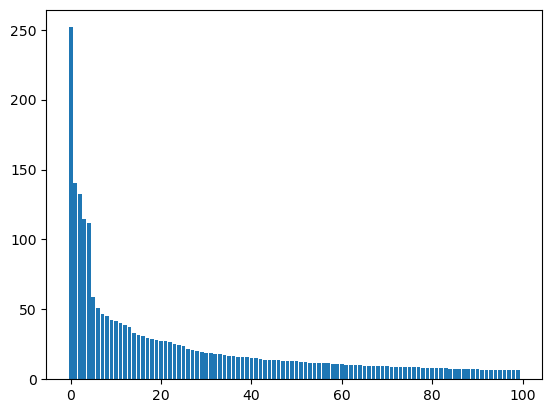

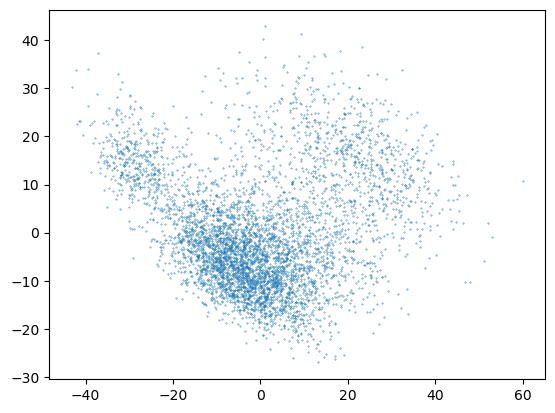

d-specific


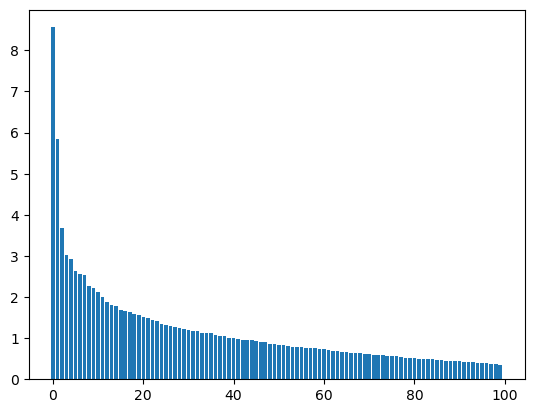

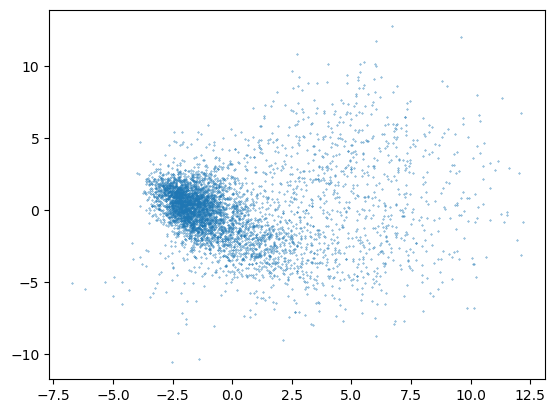

cd3
shared


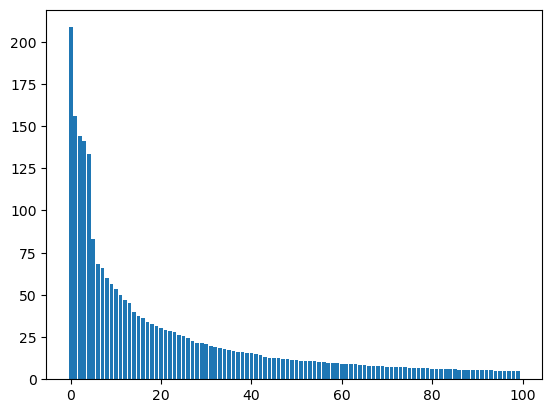

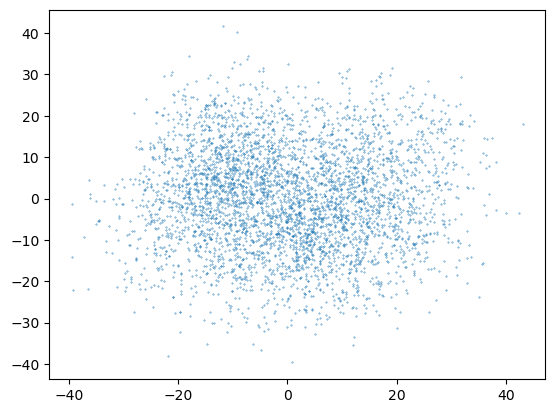

d-specific


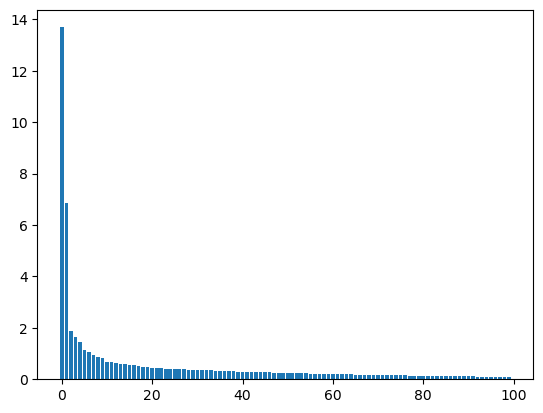

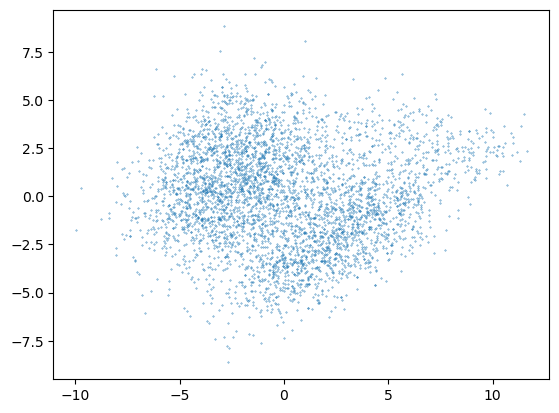

cd4
shared


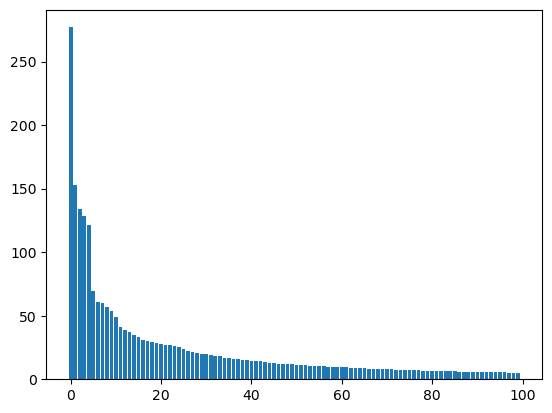

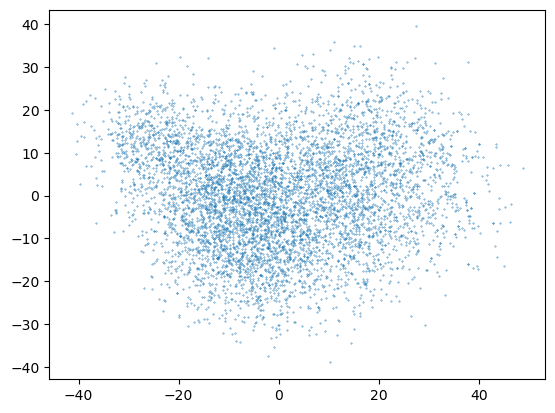

d-specific


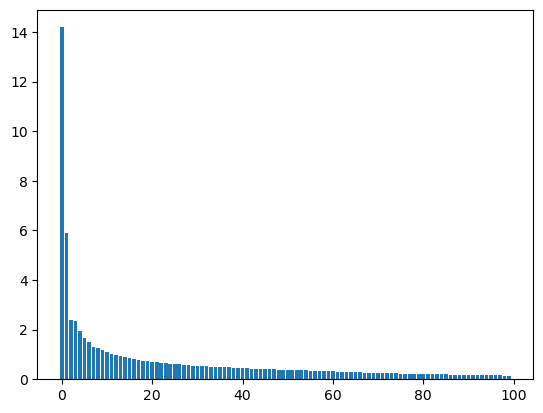

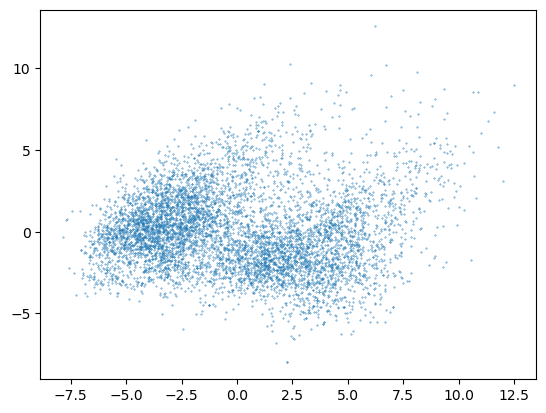

cd8
shared


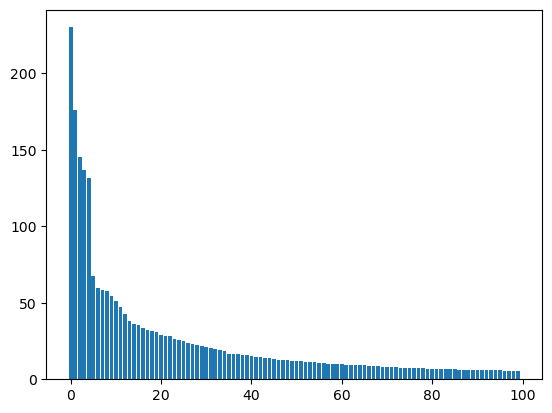

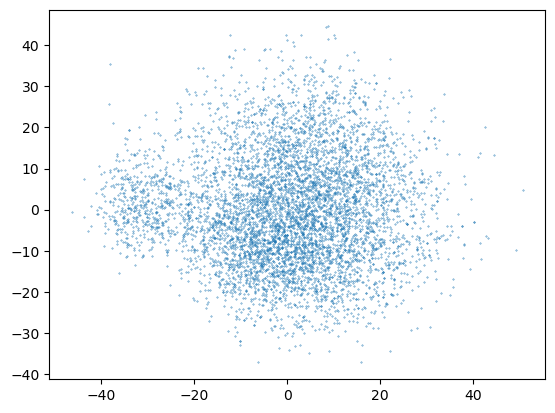

d-specific


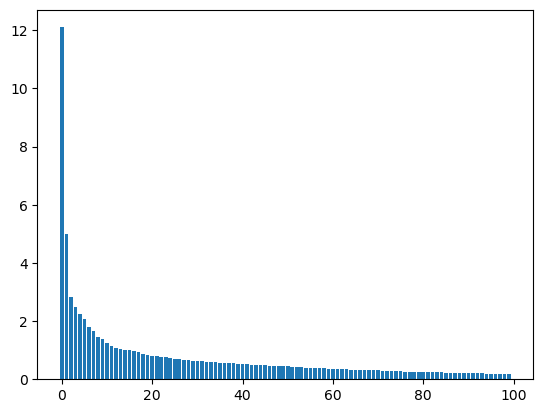

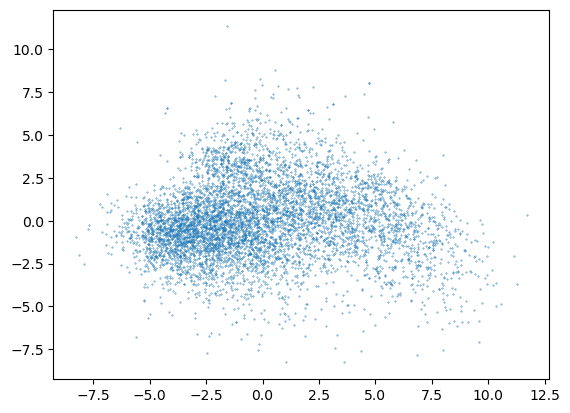

gh2ax
shared


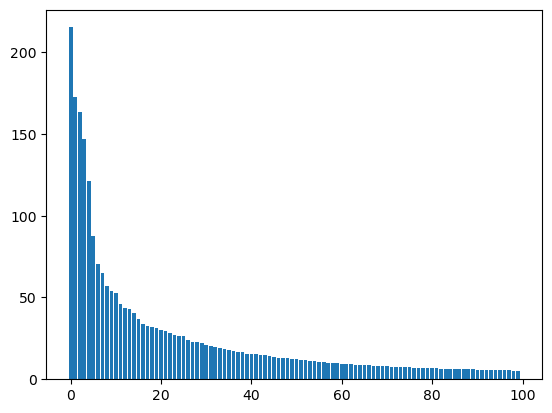

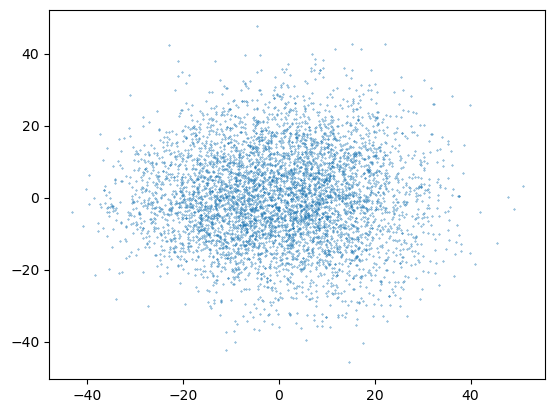

d-specific


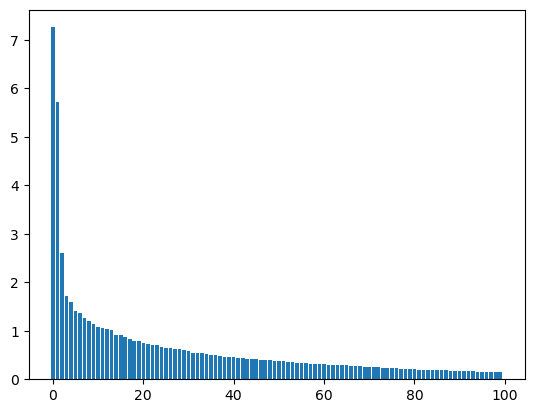

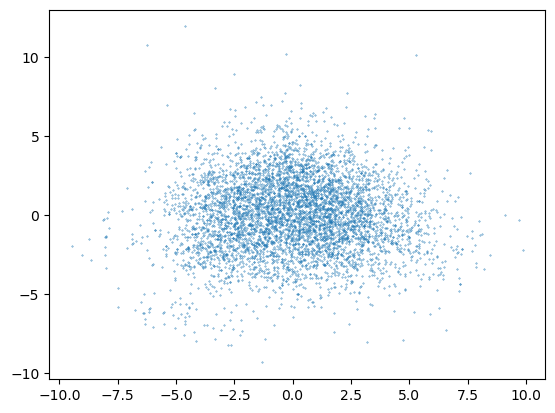

lamin
shared


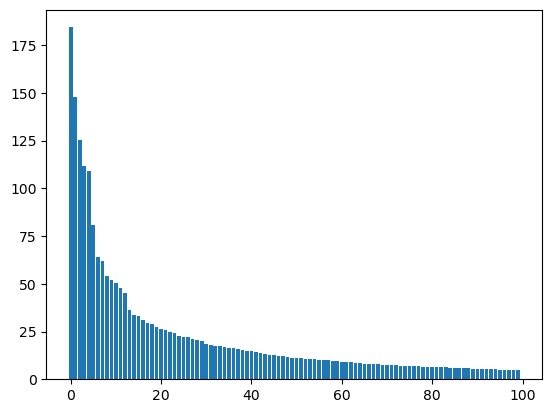

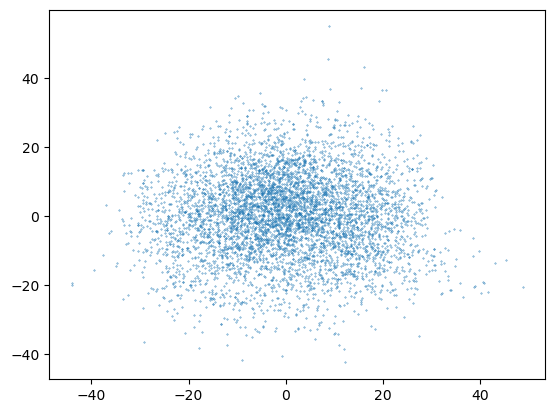

d-specific


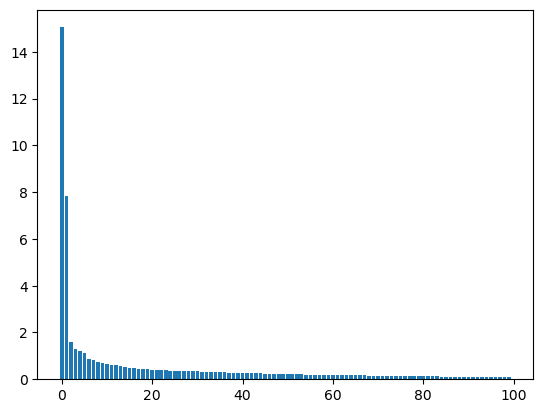

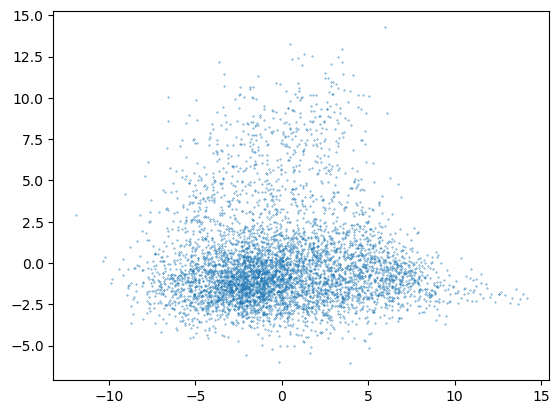

In [7]:
pca_train_shared={}
pca_train_d={}

for p_curr in np.unique(proteinNames):
    print(p_curr)
    
    #training samples
    pca_train_shared[p_curr]=PCA()
    pca_train_d[p_curr]=PCA()
    pca_train_shared[p_curr].fit(latent_train_shared[p_curr])
    pca_train_d[p_curr].fit(latent_train_d[p_curr])
    
    print('shared')
    plt.bar(np.arange(100),pca_train_shared[p_curr].explained_variance_[:100])
    plt.show()
    latent_shared_pca=pca_train_shared[p_curr].transform(latent_train_shared[p_curr])
    plt.scatter(latent_shared_pca[:,0],latent_shared_pca[:,1],s=0.1)
    plt.show()
    
    print('d-specific')
    plt.bar(np.arange(100),pca_train_d[p_curr].explained_variance_[:100])
    plt.show()
    latent_d_pca=pca_train_d[p_curr].transform(latent_train_d[p_curr])
    plt.scatter(latent_d_pca[:,0],latent_d_pca[:,1],s=0.1)
    plt.show()
    
    

### sample cells along top pcs

In [10]:
nPC=15
nSteps=11 
centerBinIdx=5
percentiles=(np.arange(nSteps-1)+1)*100/nSteps
nCellsPerSample=30
pca_train_sampledCells_shared={}
pca_train_sampledCells_d={}

for p_curr in np.unique(proteinNames):
    print(p_curr)
    allIdx=np.arange(np.sum(proteinNames==p_curr))
    
    pca_train_sampledCells_shared[p_curr]=[None]*nPC
    pca_train_sampledCells_d[p_curr]=[None]*nPC
    
    latent_shared_pca=pca_train_shared[p_curr].transform(latent_train_shared[p_curr])[:,:nPC]
    latent_shared_pca_percentile=np.percentile(latent_shared_pca,percentiles,axis=0)
    latent_shared_pca_max=np.max(latent_shared_pca,axis=0)
    latent_shared_pca_min=np.min(latent_shared_pca,axis=0)
    latent_d_pca=pca_train_d[p_curr].transform(latent_train_d[p_curr])[:,:nPC]
    latent_d_pca_percentile=np.percentile(latent_d_pca,percentiles,axis=0)
    latent_d_pca_max=np.max(latent_d_pca,axis=0)
    latent_d_pca_min=np.min(latent_d_pca,axis=0)
    dist2origin_shared=np.square(latent_shared_pca)
    dist2origin_d=np.square(latent_d_pca)
    for pc_i in range(nPC):
        pca_train_sampledCells_shared[p_curr][pc_i]=[None]*(nSteps)
        pca_train_sampledCells_d[p_curr][pc_i]=[None]*(nSteps)

        #idx of cells at the center of other pcs
        dist2origin_shared_i=np.sum(dist2origin_shared[:,:pc_i],axis=1)+np.sum(dist2origin_shared[:,pc_i+1:],axis=1)
        thresh_shared_i=np.percentile(dist2origin_shared_i,15)
        dist2origin_d_i=np.sum(dist2origin_d[:,:pc_i],axis=1)+np.sum(dist2origin_d[:,pc_i+1:],axis=1)
        thresh_d_i=np.percentile(dist2origin_d_i,15)
        centerIdx_shared=dist2origin_shared_i<thresh_shared_i
        centerIdx_d=dist2origin_d_i<thresh_d_i
        print(np.sum(centerIdx_shared))
        print(np.sum(centerIdx_d))
        print('\n')
        
        for sidx in range(nSteps):
            if sidx==0:
                min_shared_s=latent_shared_pca_min[pc_i]
                min_d_s=latent_d_pca_min[pc_i]
            else:
                min_shared_s=latent_shared_pca_percentile[sidx-1,pc_i]
                min_d_s=latent_d_pca_percentile[sidx-1,pc_i]
            if sidx==nSteps-1:
                max_shared_s=latent_shared_pca_max[pc_i]
                max_d_s=latent_d_pca_max[pc_i]
            else:
                max_shared_s=latent_shared_pca_percentile[sidx,pc_i]
                max_d_s=latent_d_pca_percentile[sidx,pc_i]
            
            sharedIdx_all=np.copy(allIdx[np.logical_and(np.logical_and(centerIdx_shared,latent_shared_pca[:,pc_i]>min_shared_s),latent_shared_pca[:,pc_i]<=max_shared_s)])
            np.random.seed(3)
            np.random.shuffle(sharedIdx_all)
            pca_train_sampledCells_shared[p_curr][pc_i][sidx]=sharedIdx_all[:nCellsPerSample]
            
            dIdx_all=np.copy(allIdx[np.logical_and(np.logical_and(centerIdx_d,latent_d_pca[:,pc_i]>min_d_s),latent_d_pca[:,pc_i]<=max_d_s)])
            np.random.seed(3)
            np.random.shuffle(dIdx_all)
            pca_train_sampledCells_d[p_curr][pc_i][sidx]=dIdx_all[:nCellsPerSample]
            
            


cd16
761
761


761
761


761
761


761
761


761
761


761
761


761
761


761
761


761
761


761
761


761
761


761
760


761
761


761
761


761
761


cd3
634
634


634
634


634
634


634
634


634
634


634
634


634
634


634
634


634
634


634
634


634
634


634
634


634
634


634
634


634
634


cd4
938
938


938
938


938
938


938
938


938
938


938
938


938
938


938
938


938
938


938
938


938
938


938
938


938
938


938
938


938
938


cd8
942
942


942
942


942
942


942
942


942
942


942
942


942
942


942
942


942
942


942
942


942
942


942
942


942
942


942
942


942
942


gh2ax
819
819


819
819


819
819


819
819


819
819


819
819


819
819


819
819


819
819


819
819


819
819


819
819


819
819


819
819


819
819


lamin
819
819


819
819


819
819


819
819


819
819


819
818


819
819


819
819


819
819


819
819


819
819


819
819


819
819


819
819


819
819




### gradients weighted by pc direction

In [12]:
blanksize=5

# shared
for p_curr in np.unique(proteinNames):
    print(p_curr)
    plotsavepath_lord_p=os.path.join(plotsavepath_lord,p_curr,'centerOtherPCs_percentile_noHeldOut')
    if not os.path.exists(plotsavepath_lord_p):
        os.mkdir(plotsavepath_lord_p)
    
    for pc_i in range(nPC):
        print(pc_i)
        resImg=np.zeros(((outSize+blanksize)*nCellsPerSample,(outSize+blanksize)*(nSteps),3))
        
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor([starget_index]).long().cuda()
        
        for sidx in range(nSteps):
            ncells=pca_train_sampledCells_shared[p_curr][pc_i][sidx].size
            for cell_i in range(ncells):
                resImg[cell_i*(outSize+blanksize):cell_i*(outSize+blanksize)+outSize,sidx*(outSize+blanksize):sidx*(outSize+blanksize)+outSize,0]=imgsP_all[proteinNames==p_curr][pca_train_sampledCells_shared[p_curr][pc_i][sidx]][cell_i,0]
                
        plt.imsave(os.path.join(plotsavepath_lord_p,str(pc_i)+'latentpc_shared_imgOnly.pdf'),resImg[:,:,0])

cd16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
cd3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
cd4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
cd8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
gh2ax
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
lamin
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [13]:
blanksize=5

# shared - minmax-scaled
for p_curr in np.unique(proteinNames):
    print(p_curr)
    plotsavepath_lord_p=os.path.join(plotsavepath_lord,p_curr,'centerOtherPCs_percentile_noHeldOut')
    if not os.path.exists(plotsavepath_lord_p):
        os.mkdir(plotsavepath_lord_p)
    
    for pc_i in range(nPC):
        print(pc_i)
        resImg=np.zeros(((outSize+blanksize)*nCellsPerSample,(outSize+blanksize)*(nSteps),3))
        
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor([starget_index]).long().cuda()
        
        for sidx in range(nSteps):
            ncells=pca_train_sampledCells_shared[p_curr][pc_i][sidx].size
            for cell_i in range(ncells):
                valtarget_p=imgsP_all[proteinNames==p_curr][pca_train_sampledCells_shared[p_curr][pc_i][sidx]][[cell_i]]
                resImg[cell_i*(outSize+blanksize):cell_i*(outSize+blanksize)+outSize,sidx*(outSize+blanksize):sidx*(outSize+blanksize)+outSize,0]=(valtarget_p[0,0]-np.min(valtarget_p[0,0]))/(np.max(valtarget_p[0,0])-np.min(valtarget_p[0,0]))
                
        plt.imsave(os.path.join(plotsavepath_lord_p,str(pc_i)+'latentpc_shared_minmaxScaledImg_imgOnly.pdf'),resImg[:,:,0])

cd16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
cd3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
cd4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
cd8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
gh2ax
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
lamin
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [14]:
blanksize=5

# d-specific
for p_curr in np.unique(proteinNames):
    print(p_curr)
    plotsavepath_lord_p=os.path.join(plotsavepath_lord,p_curr,'centerOtherPCs_percentile_noHeldOut')
    if not os.path.exists(plotsavepath_lord_p):
        os.mkdir(plotsavepath_lord_p)
    
    for pc_i in range(nPC):
        resImg=np.zeros(((outSize+blanksize)*nCellsPerSample,(outSize+blanksize)*(nSteps),3))
        
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor([starget_index]).long().cuda()
        
        for sidx in range(nSteps):
            ncells=pca_train_sampledCells_d[p_curr][pc_i][sidx].size
            for cell_i in range(ncells):
                resImg[cell_i*(outSize+blanksize):cell_i*(outSize+blanksize)+outSize,sidx*(outSize+blanksize):sidx*(outSize+blanksize)+outSize,0]=imgsP_all[proteinNames==p_curr][pca_train_sampledCells_d[p_curr][pc_i][sidx]][cell_i,0]
                
        plt.imsave(os.path.join(plotsavepath_lord_p,str(pc_i)+'latentpc_d_imgOnly.pdf'),resImg[:,:,0])

cd16
cd3
cd4
cd8
gh2ax
lamin


In [15]:
blanksize=5

# d-specific - minmax-scaled
for p_curr in np.unique(proteinNames):
    print(p_curr)
    plotsavepath_lord_p=os.path.join(plotsavepath_lord,p_curr,'centerOtherPCs_percentile_noHeldOut')
    if not os.path.exists(plotsavepath_lord_p):
        os.mkdir(plotsavepath_lord_p)
    
    for pc_i in range(nPC):
        resImg=np.zeros(((outSize+blanksize)*nCellsPerSample,(outSize+blanksize)*(nSteps),3))
        
        starget_index=pnames.tolist().index(p_curr)
        plabels=torch.tensor([starget_index]).long().cuda()
        
        for sidx in range(nSteps):
            ncells=pca_train_sampledCells_d[p_curr][pc_i][sidx].size
            for cell_i in range(ncells):
                valtarget_p=imgsP_all[proteinNames==p_curr][pca_train_sampledCells_d[p_curr][pc_i][sidx]][[cell_i]]
                resImg[cell_i*(outSize+blanksize):cell_i*(outSize+blanksize)+outSize,sidx*(outSize+blanksize):sidx*(outSize+blanksize)+outSize,0]=(valtarget_p[0,0]-np.min(valtarget_p[0,0]))/(np.max(valtarget_p[0,0])-np.min(valtarget_p[0,0]))
                
        plt.imsave(os.path.join(plotsavepath_lord_p,str(pc_i)+'latentpc_d_minmaxScaledImg_imgOnly.pdf'),resImg[:,:,0])

cd16
cd3
cd4
cd8
gh2ax
lamin


### compute latent PCA - chromatin

In [16]:
#training samples
plabels=torch.tensor(revIdx).long()
valIdx=np.arange(proteinNames.size)
latent_train_shared_dna=np.zeros((proteinNames.size,sharedSizes[0]))
latent_train_d_dna=np.zeros((proteinNames.size,dSpecificSize))
nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
with torch.no_grad():
    for i in range(nvalBatches):
        valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
        valtarget_p=torch.tensor(imgsC_all[valIdx_i]).cuda().float()
        valInput_ID=plabels[valIdx_i].cuda()
        valIdx_i=torch.tensor(valIdx_i)

        reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_p,valInput_ID)

        latent_train_shared_dna[valIdx_i]=reconShared_dna_l.cpu().numpy()
        latent_train_d_dna[valIdx_i]=recon_dna_l.cpu().numpy()
    


shared


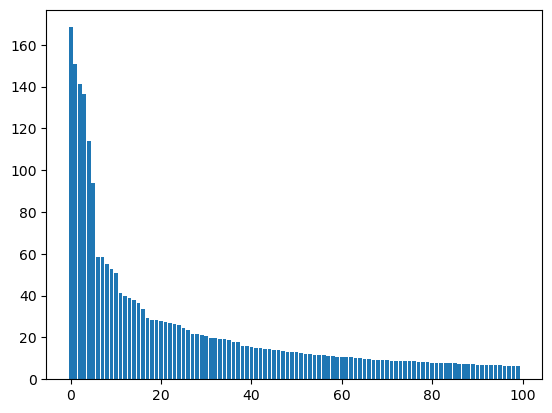

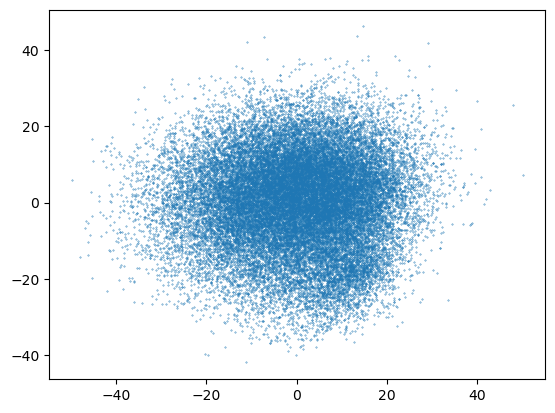

d-specific


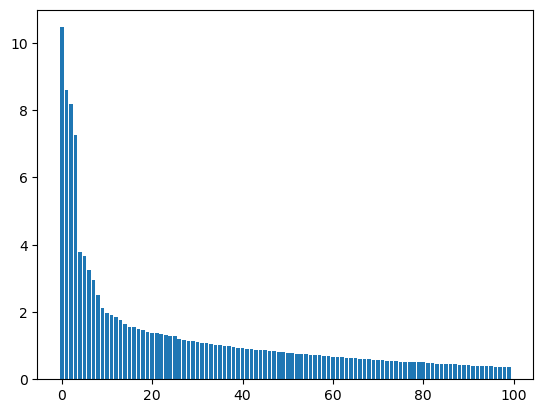

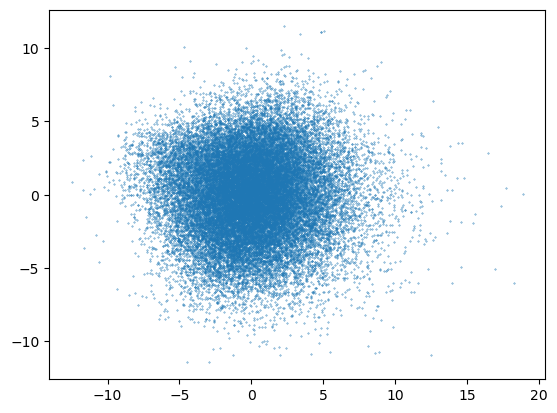

In [17]:
pca_train_shared_dna=PCA()
pca_train_d_dna=PCA()
pca_train_shared_dna.fit(latent_train_shared_dna)
pca_train_d_dna.fit(latent_train_d_dna)

print('shared')
plt.bar(np.arange(100),pca_train_shared_dna.explained_variance_[:100])
plt.show()
latent_shared_pca=pca_train_shared_dna.transform(latent_train_shared_dna)
plt.scatter(latent_shared_pca[:,0],latent_shared_pca[:,1],s=0.1)
plt.show()

print('d-specific')
plt.bar(np.arange(100),pca_train_d_dna.explained_variance_[:100])
plt.show()
latent_d_pca=pca_train_d_dna.transform(latent_train_d_dna)
plt.scatter(latent_d_pca[:,0],latent_d_pca[:,1],s=0.1)
plt.show()

    

### sample cells along top pcs

In [18]:
nPC=20
nSteps=11 
centerBinIdx=5
percentiles=(np.arange(nSteps-1)+1)*100/nSteps
nCellsPerSample=30
allIdx=np.arange(proteinNames.size)

pca_train_sampledCells_shared_dna=[None]*nPC
pca_train_sampledCells_d_dna=[None]*nPC

latent_shared_pca=pca_train_shared_dna.transform(latent_train_shared_dna)[:,:nPC]
latent_shared_pca_percentile=np.percentile(latent_shared_pca,percentiles,axis=0)
latent_shared_pca_max=np.max(latent_shared_pca,axis=0)
latent_shared_pca_min=np.min(latent_shared_pca,axis=0)
latent_d_pca=pca_train_d_dna.transform(latent_train_d_dna)[:,:nPC]
latent_d_pca_percentile=np.percentile(latent_d_pca,percentiles,axis=0)
latent_d_pca_max=np.max(latent_d_pca,axis=0)
latent_d_pca_min=np.min(latent_d_pca,axis=0)
dist2origin_shared=np.square(latent_shared_pca)
dist2origin_d=np.square(latent_d_pca)
for pc_i in range(nPC):
    pca_train_sampledCells_shared_dna[pc_i]=[None]*(nSteps)
    pca_train_sampledCells_d_dna[pc_i]=[None]*(nSteps)

    #idx of cells at the center of other pcs
    dist2origin_shared_i=np.sum(dist2origin_shared[:,:pc_i],axis=1)+np.sum(dist2origin_shared[:,pc_i+1:],axis=1)
    thresh_shared_i=np.percentile(dist2origin_shared_i,15)
    dist2origin_d_i=np.sum(dist2origin_d[:,:pc_i],axis=1)+np.sum(dist2origin_d[:,pc_i+1:],axis=1)
    thresh_d_i=np.percentile(dist2origin_d_i,15)
    centerIdx_shared=dist2origin_shared_i<thresh_shared_i
    centerIdx_d=dist2origin_d_i<thresh_d_i
    print(np.sum(centerIdx_shared))
    print(np.sum(centerIdx_d))
    print('\n')

    for sidx in range(nSteps):
        if sidx==0:
            min_shared_s=latent_shared_pca_min[pc_i]
            min_d_s=latent_d_pca_min[pc_i]
        else:
            min_shared_s=latent_shared_pca_percentile[sidx-1,pc_i]
            min_d_s=latent_d_pca_percentile[sidx-1,pc_i]
        if sidx==nSteps-1:
            max_shared_s=latent_shared_pca_max[pc_i]
            max_d_s=latent_d_pca_max[pc_i]
        else:
            max_shared_s=latent_shared_pca_percentile[sidx,pc_i]
            max_d_s=latent_d_pca_percentile[sidx,pc_i]

        sharedIdx_all=np.copy(allIdx[np.logical_and(np.logical_and(centerIdx_shared,latent_shared_pca[:,pc_i]>min_shared_s),latent_shared_pca[:,pc_i]<=max_shared_s)])
        np.random.seed(3)
        np.random.shuffle(sharedIdx_all)
        pca_train_sampledCells_shared_dna[pc_i][sidx]=sharedIdx_all[:nCellsPerSample]

        dIdx_all=np.copy(allIdx[np.logical_and(np.logical_and(centerIdx_d,latent_d_pca[:,pc_i]>min_d_s),latent_d_pca[:,pc_i]<=max_d_s)])
        np.random.seed(3)
        np.random.shuffle(dIdx_all)
        pca_train_sampledCells_d_dna[pc_i][sidx]=dIdx_all[:nCellsPerSample]




4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913


4913
4913




In [19]:
blanksize=5

# shared - minmax-scaled
p_curr='chromatin'
print(p_curr)
plotsavepath_lord_p=os.path.join(plotsavepath_lord,p_curr,'centerOtherPCs_percentile_noHeldOut')
if not os.path.exists(plotsavepath_lord_p):
    os.mkdir(plotsavepath_lord_p)
    
plabels=torch.tensor(revIdx).long()
for pc_i in range(nPC):
    resImg=np.zeros(((outSize+blanksize)*nCellsPerSample,(outSize+blanksize)*(nSteps),3))

    for sidx in range(nSteps):
        ncells=pca_train_sampledCells_shared_dna[pc_i][sidx].size
        for cell_i in range(ncells):
            valtarget_p=imgsC_all[pca_train_sampledCells_shared_dna[pc_i][sidx]][[cell_i]]
            resImg[cell_i*(outSize+blanksize):cell_i*(outSize+blanksize)+outSize,sidx*(outSize+blanksize):sidx*(outSize+blanksize)+outSize,0]=(valtarget_p[0,0]-np.min(valtarget_p[0,0]))/(np.max(valtarget_p[0,0])-np.min(valtarget_p[0,0]))

    plt.imsave(os.path.join(plotsavepath_lord_p,str(pc_i)+'latentpc_shared_minmaxScaledImg_imgOnly.pdf'),resImg[:,:,0])

chromatin


In [20]:
blanksize=5

# d - minmax-scaled
p_curr='chromatin'
print(p_curr)
plotsavepath_lord_p=os.path.join(plotsavepath_lord,p_curr,'centerOtherPCs_percentile_noHeldOut')
if not os.path.exists(plotsavepath_lord_p):
    os.mkdir(plotsavepath_lord_p)
    
plabels=torch.tensor(revIdx).long()
for pc_i in range(nPC):
    resImg=np.zeros(((outSize+blanksize)*nCellsPerSample,(outSize+blanksize)*(nSteps),3))

    for sidx in range(nSteps):
        ncells=pca_train_sampledCells_d_dna[pc_i][sidx].size
        for cell_i in range(ncells):
            valtarget_p=imgsC_all[pca_train_sampledCells_d_dna[pc_i][sidx]][[cell_i]]
            resImg[cell_i*(outSize+blanksize):cell_i*(outSize+blanksize)+outSize,sidx*(outSize+blanksize):sidx*(outSize+blanksize)+outSize,0]=(valtarget_p[0,0]-np.min(valtarget_p[0,0]))/(np.max(valtarget_p[0,0])-np.min(valtarget_p[0,0]))

    plt.imsave(os.path.join(plotsavepath_lord_p,str(pc_i)+'latentpc_d_minmaxScaledImg_imgOnly.pdf'),resImg[:,:,0])

chromatin
